### Install and import packages

In [2]:
# Import packages
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_palette("tab10")

import random as rnd
import numpy as np
rnd.seed(0)
np.random.seed(0)

import scipy.stats as stats
import bayes_logistic
from pypolyagamma import PyPolyaGamma

from utils import *

### Generate data_x

In [25]:
### Generate data_x
# params
num_data = 1000
num_feats = 2

data_x = stats.uniform.rvs(0, 1, size=(num_data, num_feats), random_state=12345)
# data_x = np.array([[0, 1], [1, 0]])
# print(data_x)
print(data_x.shape)

(1000, 2)


### PolyaGamma Inference function

In [4]:
def gibbs_sample_polyagamma(
    X, y, pg_dist, pg_init_mu, pg_init_cov, burnin_steps, num_samples_i):
    #
    num_data, num_feats = X.shape

    # Gibbs sampling with PG augmentation for burnin_steps
    # init params for gibb sampling are set to be the same as params of prior
    beta_mu = pg_init_mu
    beta_cov = pg_init_cov
    beta_hat = np.random.multivariate_normal(beta_mu, beta_cov)
    k = y - 1/2

    # pg = PyPolyaGamma(seed=0)
    # perform Gibbs sampling
    for bid in range(burnin_steps+1):
        # ω ~ PG(b, c) = PG(1, x*β).
        omega_b = np.ones(num_data)
        omega_c = X @ beta_hat
        omega_diag = np.array(
            [pg_dist.pgdraw(b, c) for b, c in zip(omega_b, omega_c)])

        # β ~ N(m, V).
        V = np.linalg.inv(X.T @ np.diag(omega_diag) @ X + np.linalg.inv(beta_cov))
        m = np.dot(V, X.T @ k + np.linalg.inv(beta_cov) @ beta_mu)
        beta_hat = np.random.multivariate_normal(m, V)
        # print(m)
    # stop
    if num_samples_i == 0:
        return beta_hat, _
    
    # samples
    beta_hat_return = beta_hat
    beta_samples = [beta_hat]
    num_samples_i -= 1
    length = 10
    for sidx in range(num_samples_i*length):
        # ω ~ PG(b, c) = PG(1, x*β).
        omega_b = np.ones(num_data)
        omega_c = X @ beta_hat
        omega_diag = np.array(
            [pg_dist.pgdraw(b, c) for b, c in zip(omega_b, omega_c)])

        # β ~ N(m, V).
        V = np.linalg.inv(X.T @ np.diag(omega_diag) @ X + np.linalg.inv(beta_cov))
        m = np.dot(V, X.T @ k + np.linalg.inv(beta_cov) @ beta_mu)
        beta_hat = np.random.multivariate_normal(m, V)
        beta_samples.append(beta_hat)
        
    beta_samples = beta_samples[0:num_samples_i*length+1:length]
    beta_samples = np.vstack(beta_samples)
    
    return beta_hat_return, beta_samples


### Generate prior and posterior samples

In [26]:
### Generate prior and posterior samples
np.random.seed(0)

# num_samples 
num_samples = 1000

# weights prior distribution parameters
weights_prior_params = [
    [[0.0, 0.0], [[1.0, 0.0], [0.0, 1.0]]],
    [[3.0, 3.0], [[1.0, 0.0], [0.0, 1.0]]]]
mix_weights = [0.5, 0.5]

# num burnin_steps
pg_burnin_steps = 100

# pg_init_wprior = np.random.randn(2)
# pg_init_wprior = np.array(weights_prior_params[0][0])
init_mixtures = [0.3, 0.7]
init_mixtures = mix_weights
pg_init_mu = \
    init_mixtures[0]*np.array(weights_prior_params[0][0]) \
    + init_mixtures[1]*np.array(weights_prior_params[1][0])

pg_init_cov = \
    init_mixtures[0]*np.array(weights_prior_params[0][1]) \
    + init_mixtures[1]*np.array(weights_prior_params[1][1])
print(pg_init_mu)
print(pg_init_cov)

# generate samples A of weights prior
samples_a_weights_prior = np.concatenate([stats.multivariate_normal.rvs(
    mu, cov, size=(num_samples), random_state=1)[:,:,None] \
        for mu, cov in weights_prior_params], axis=-1)
samples_a_mixture = stats.multinomial.rvs(1, mix_weights, size=(num_samples), random_state=1)[:,None,:]
samples_a_weights_prior = np.sum(np.multiply(samples_a_weights_prior, samples_a_mixture), axis=-1)

# generate samples B of weights prior
samples_b_weights_prior = np.concatenate([stats.multivariate_normal.rvs(
    mu, cov, size=(num_samples), random_state=11)[:,:,None] \
        for mu, cov in weights_prior_params], axis=-1)
samples_b_mixture = stats.multinomial.rvs(1, mix_weights, size=(num_samples), random_state=11)[:,None,:]
samples_b_weights_prior = np.sum(np.multiply(samples_b_weights_prior, samples_b_mixture), axis=-1)

samples_a_weights_posterior = []
samples_a_weights_posterior_all = []
idxes = list(np.random.randint(0, num_samples, size=5))
idxes = [0, 4, 10, 20, 100]
idxes = []

pg_dist = PyPolyaGamma(seed=0)
for sidx in range(num_samples):
    num_samples_i = 0
    if sidx in idxes:
        num_samples_i = 10000
        
    # for each sample w_i in A
    sample_a_weights_prior = samples_a_weights_prior[sidx].reshape(1, num_feats)
    
    # generate sample y_i from Ber(x, w_i)
    sample_a_logit = 1.0 / (1 + np.exp(-np.matmul(data_x, sample_a_weights_prior.T)))
    sample_a_y = stats.bernoulli.rvs(sample_a_logit)   

    # sample weights' posterior p(w|x,y_i) using polyagamma inference
    sample_a_weights_posterior, samples_w = gibbs_sample_polyagamma(
        data_x, sample_a_y.squeeze(-1), 
        pg_dist, pg_init_mu, pg_init_cov, burnin_steps=pg_burnin_steps, 
        num_samples_i=num_samples_i)
    
    samples_a_weights_posterior.append(sample_a_weights_posterior) 
    if sidx in idxes:
        print(len(samples_w))
        samples_a_weights_posterior_all.append([samples_w])
    
samples_a_weights_prior = np.vstack(samples_a_weights_prior)
samples_b_weights_prior = np.vstack(samples_b_weights_prior)
samples_a_weights_posterior = np.vstack(samples_a_weights_posterior)
print(samples_a_weights_prior.shape)
# print(samples_b_weights_prior)
# print(samples_a_weights_posterior)

[1.5 1.5]
[[1. 0.]
 [0. 1.]]
(1000, 2)


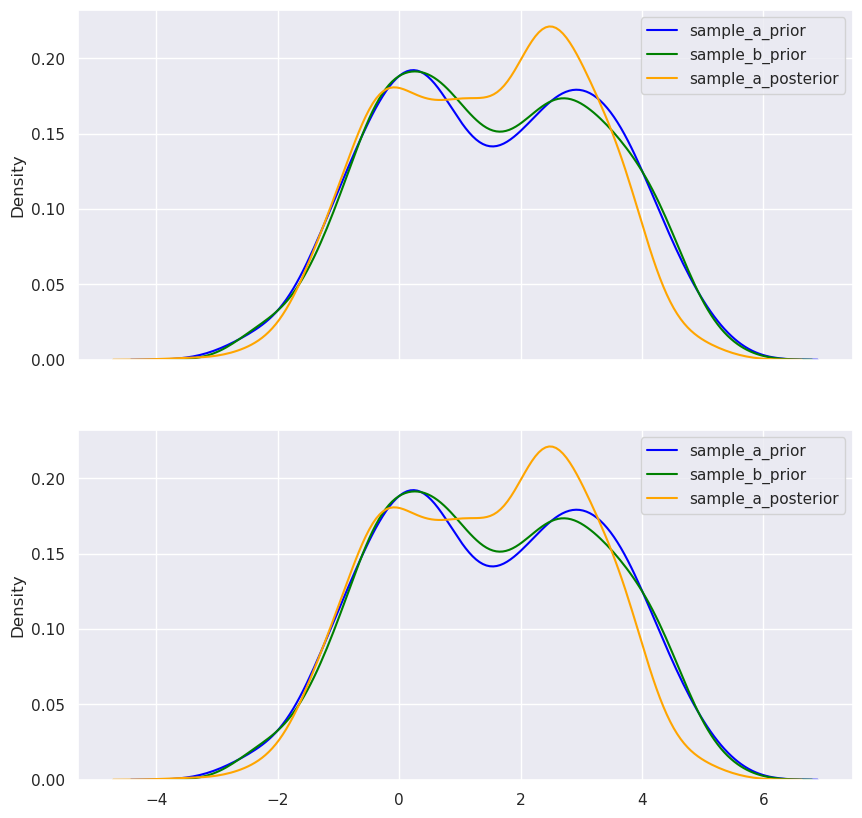

In [17]:
# Visualize the generated prior and posterior samples 
nrows = 2
fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex=True, sharey=True, figsize=(10,10))
axes = axes.flatten()

for i in range(nrows):
    sns.kdeplot(samples_a_weights_prior[:,0], fill=False, color="blue", label="sample_a_prior", ax=axes[i])
    sns.kdeplot(samples_b_weights_prior[:,0], fill=False, color="green", label="sample_b_prior", ax=axes[i])
    sns.kdeplot(samples_a_weights_posterior[:,0], fill=False, color="orange", label="sample_a_posterior", ax=axes[i])
    axes[i].legend()
plt.show()

IndexError: list index out of range

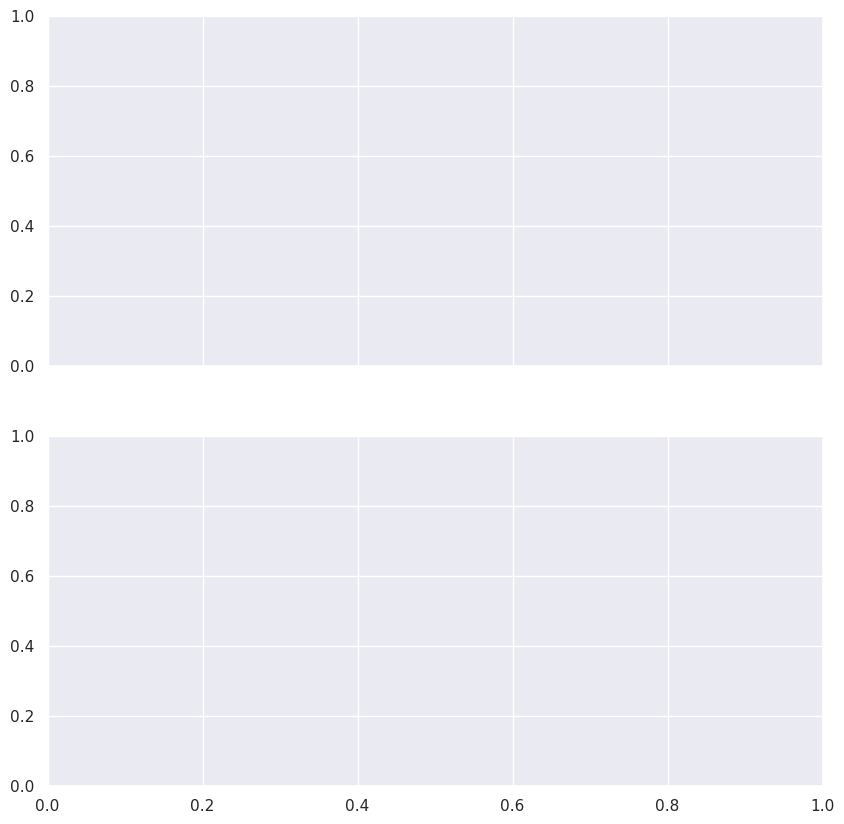

In [16]:
# # Visualize the generated prior and posterior samples, individual features
# nrows = 2
# fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex=True, sharey=True, figsize=(10,10))
# axes = axes.flatten()

# num_hist = 5
# print(samples_a_weights_posterior_all[0][0].shape)
# for i in range(nrows):
#     sns.kdeplot(samples_a_weights_prior[:,i], fill=False, color="blue", label="samples_a_prior", ax=axes[i])
#     sns.kdeplot(samples_b_weights_prior[:,i], fill=False, color="green", label="samples_b_prior", ax=axes[i])
#     sns.kdeplot(samples_a_weights_posterior[:,i], fill=False, color="orange", label="samples_a_posterior", ax=axes[i])
#     for j in range(num_hist):
#         samples_a_weights_posterior_j = samples_a_weights_posterior_all[j][0]
#         sns.kdeplot(samples_a_weights_posterior_j[:,i], fill=False, color="red", 
#                     label=f"samples_a_posterior_{j}", ax=axes[i])
#     axes[i].legend()
# plt.show()

In [8]:
# # Visualize the generated prior and posterior samples 
# fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10,10))
# axes = axes.flatten()

# sns.kdeplot(x=samples_a_weights_prior[:,0], y=samples_a_weights_prior[:,1], n_levels=20, 
#             cmap="inferno", fill=False, cbar=True, ax=axes[0])

# sns.kdeplot(x=samples_b_weights_prior[:,0], y=samples_b_weights_prior[:,1], n_levels=20, 
#             cmap="inferno", fill=False, cbar=True, ax=axes[1])

# sns.kdeplot(x=samples_a_weights_posterior[:,0], y=samples_a_weights_posterior[:,1], n_levels=20, 
#             cmap="inferno", fill=False, cbar=True, ax=axes[2])
# axes[0].set_title("sample_a_prior")
# axes[1].set_title("sample_b_prior")
# axes[2].set_title("sample_a_posterior")
# plt.show()

### Measure the differences between the prior and samples

* Kernelized two sample test: maximum mean distance with RBF kernel
* Wasserstein distance of two samples
* Difference between the standard deviations (from true mean) of two samples

In [27]:
# Maximum mean distance with RBF kernel
mmd_rbf_prior_a_prior_b = compute_mmd_rbf(samples_a_weights_prior, samples_b_weights_prior)
mmd_rbf_posterior_a_prior_b = compute_mmd_rbf(samples_a_weights_posterior, samples_b_weights_prior)
print(f"MMD between prior a and prior b: {mmd_rbf_prior_a_prior_b:0.5f}")
print(f"MMD between posterior a and prior b: {mmd_rbf_posterior_a_prior_b:0.5f}")

MMD between prior a and prior b: 0.00151
MMD between posterior a and prior b: 0.00185


In [28]:
# Wasserstein distance with RBF kernel
wd_prior_a_prior_b = compute_wasserstein_distance(samples_a_weights_prior, samples_b_weights_prior)
wd_posterior_a_prior_b = compute_wasserstein_distance(samples_a_weights_posterior, samples_b_weights_prior)
print(f"Wasserstein distance between prior a and prior b: {wd_prior_a_prior_b:0.5f}")
print(f"Wasserstein distance between posterior a and prior b: {wd_posterior_a_prior_b:0.5f}")

Wasserstein distance between prior a and prior b: 0.19674
Wasserstein distance between posterior a and prior b: 0.20371


In [55]:
# Difference between the standard deviations (from true mean) of two samples
diff_std_prior_a_prior_b = compute_diff_std(samples_a_weights_prior, samples_b_weights_prior, weights_prior_params[0])
diff_std_posterior_a_prior_b = compute_diff_std(samples_a_weights_posterior, samples_b_weights_prior, weights_prior_params[0])
print(f"Difference standard deviations between between prior a and prior b: {diff_std_prior_a_prior_b:0.5f}")
print(f"Difference standard deviations between posterior a and prior b: {diff_std_posterior_a_prior_b:0.5f}")

Difference standard deviations between between prior a and prior b: 0.05072
Difference standard deviations between posterior a and prior b: 0.07826
